In [2]:
# --- 1. Importación de Librerías ---
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report

print("Librerías importadas.")

# --- 2. Carga de Datos ---
df = pd.read_csv('../data/creditcard.csv')
print(f"Dataset cargado con {df.shape[0]} filas.")

# --- 3. Ingeniería de Características (La Parte Nueva y Mejorada) ---
print("\n--- Iniciando Ingeniería de Características ---")

# Hacemos una copia para trabajar
df_feat = df.copy()

# Característica 1: Hora del día (de 0 a 23)
df_feat['Hour'] = (df_feat['Time'] // 3600) % 24
print("-> Columna 'Hour' creada.")

# Característica 2 y 3: Transformación cíclica de la hora
df_feat['Hour_sin'] = np.sin(2 * np.pi * df_feat['Hour'] / 24)
df_feat['Hour_cos'] = np.cos(2 * np.pi * df_feat['Hour'] / 24)
print("-> Características cíclicas 'Hour_sin' y 'Hour_cos' creadas.")

# Característica 4: Indicador de monto cero
df_feat['Amount_es_cero'] = (df_feat['Amount'] == 0).astype(int)
print("-> Característica 'Amount_es_cero' creada.")

# Ahora eliminamos las columnas originales que ya no necesitamos ('Time' y 'Hour')
df_feat = df_feat.drop(['Time', 'Hour'], axis=1)

# Normalizamos 'Amount' como antes
scaler = StandardScaler()
df_feat['Amount'] = scaler.fit_transform(df_feat['Amount'].values.reshape(-1, 1))

print("\n--- Preprocesamiento Avanzado Completo ---")
print("Vista previa de las nuevas características:")
print(df_feat[['Amount', 'Amount_es_cero', 'Hour_sin', 'Hour_cos']].head())


# --- 4. Preparación para el Modelo (igual que antes) ---
y = df_feat['Class']
X = df_feat.drop('Class', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


# --- 5. Entrenamiento y Evaluación del Modelo (igual que antes) ---
xgb_model_avanzado = XGBClassifier(
    n_estimators=100,
    max_depth=8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

print("\n--- Entrenando Modelo Avanzado... ---")
xgb_model_avanzado.fit(X_train_resampled, y_train_resampled)
print("¡Modelo entrenado!")

y_pred_avanzado = xgb_model_avanzado.predict(X_test)

print("\n--- Resultados de la Evaluación (Modelo Avanzado) ---")
print(classification_report(y_test, y_pred_avanzado, target_names=['Normal (0)', 'Fraude (1)']))

Librerías importadas.
Dataset cargado con 284807 filas.

--- Iniciando Ingeniería de Características ---
-> Columna 'Hour' creada.
-> Características cíclicas 'Hour_sin' y 'Hour_cos' creadas.
-> Característica 'Amount_es_cero' creada.

--- Preprocesamiento Avanzado Completo ---
Vista previa de las nuevas características:
     Amount  Amount_es_cero  Hour_sin  Hour_cos
0  0.244964               0       0.0       1.0
1 -0.342475               0       0.0       1.0
2  1.160686               0       0.0       1.0
3  0.140534               0       0.0       1.0
4 -0.073403               0       0.0       1.0

--- Entrenando Modelo Avanzado... ---


c:\Users\danie\Documents\Portafolio\deteccion-fraude-tarjeta-credito\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:01:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


¡Modelo entrenado!

--- Resultados de la Evaluación (Modelo Avanzado) ---
              precision    recall  f1-score   support

  Normal (0)       1.00      1.00      1.00     56864
  Fraude (1)       0.89      0.84      0.86        98

    accuracy                           1.00     56962
   macro avg       0.95      0.92      0.93     56962
weighted avg       1.00      1.00      1.00     56962



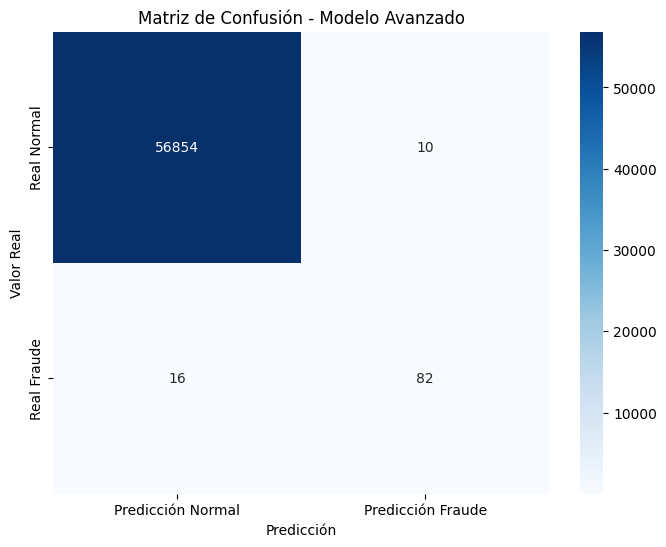

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# Asumiendo que 'y_test' son los valores reales y 'y_pred_avanzado' son tus predicciones
cm = confusion_matrix(y_test, y_pred_avanzado)

# Graficamos la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicción Normal', 'Predicción Fraude'], 
            yticklabels=['Real Normal', 'Real Fraude'])
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión - Modelo Avanzado')
plt.show()

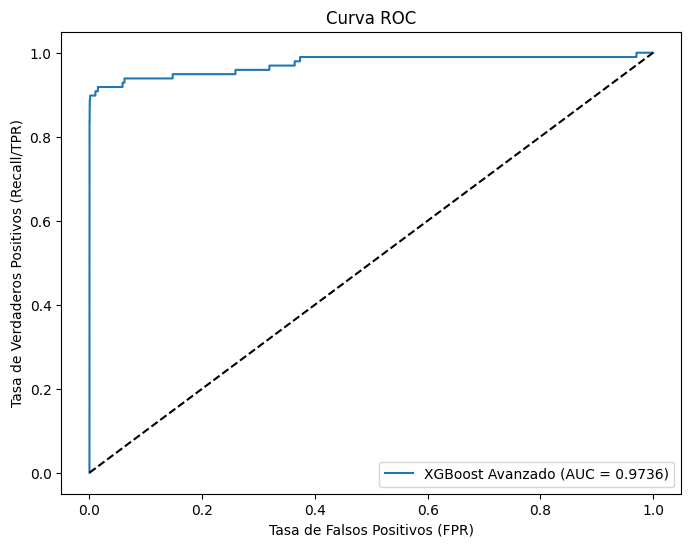

In [4]:
from sklearn.metrics import roc_curve, roc_auc_score

# Para esta gráfica, necesitamos la PROBABILIDAD de que sea fraude, no solo la predicción final
y_pred_proba = xgb_model_avanzado.predict_proba(X_test)[:, 1]

# Calcular los valores para la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc_score = roc_auc_score(y_test, y_pred_proba)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'XGBoost Avanzado (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], 'k--') # Línea de azar
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (Recall/TPR)')
plt.title('Curva ROC')
plt.legend()
plt.show()

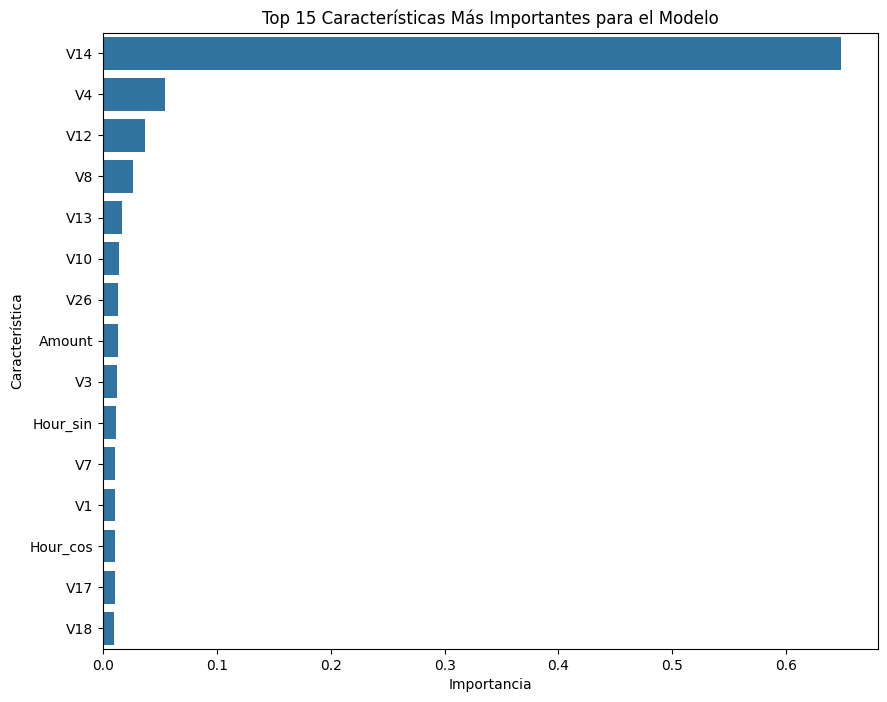

In [5]:
# Obtener la importancia de las características del modelo ya entrenado
importances = xgb_model_avanzado.feature_importances_
feature_names = X.columns # X es nuestro dataframe de características

# Crear un DataFrame para facilitar la visualización
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False).head(15) # Top 15

# Graficar la importancia
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('Top 15 Características Más Importantes para el Modelo')
plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.show()


Generando la Curva de Precisión-Recall...


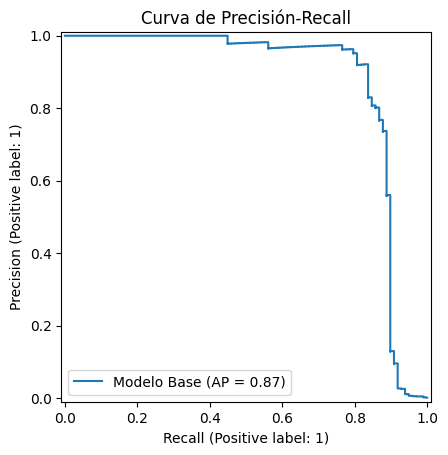

In [6]:
# --- 1. Importar las librerías necesarias ---
import matplotlib.pyplot as plt
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve

# --- 2. Obtener las probabilidades de la clase positiva (Fraude) ---
# Suponiendo que tu modelo entrenado se llama 'modelo_base' y tus datos de prueba 'X_test'
# Usamos [:, 1] para quedarnos solo con la probabilidad de la clase "1" (Fraude)
y_pred_proba = xgb_model_avanzado.predict_proba(X_test)[:, 1]

# --- 3. Generar y mostrar la curva (Método recomendado y moderno) ---

print("Generando la Curva de Precisión-Recall...")

# Creamos el objeto de la visualización directamente desde las predicciones
display = PrecisionRecallDisplay.from_predictions(y_test, y_pred_proba, name="Modelo Base")

# Personalizamos el título y lo mostramos
display.ax_.set_title("Curva de Precisión-Recall")
plt.show()